## Import processed data

In [2]:
import numpy as np

rsd = np.genfromtxt('rsd_array++.csv', delimiter=',')

assert len(rsd) == 13336

## Run DBSCAN

In [3]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(rsd)

# Compute CBSCAN
eps_value = 0.05 
db = DBSCAN(eps=eps_value, min_samples=10).fit(X)
# eps: max distance between two neighnoring samples
# min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.


In [4]:
# Mark core samples

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True # use a new list to mark every core point as True
# core_sample_indices_ : array, shape = [n_core_samples]; indices of core samples

# import collections
# collections.Counter(core_samples_mask)
# collections.Counter(db.labels_)

In [5]:
# Show some data details

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(rsd, labels))

Estimated number of clusters: 125
Estimated number of noise points: 2088
Silhouette Coefficient: -0.301


## Draw the Graph

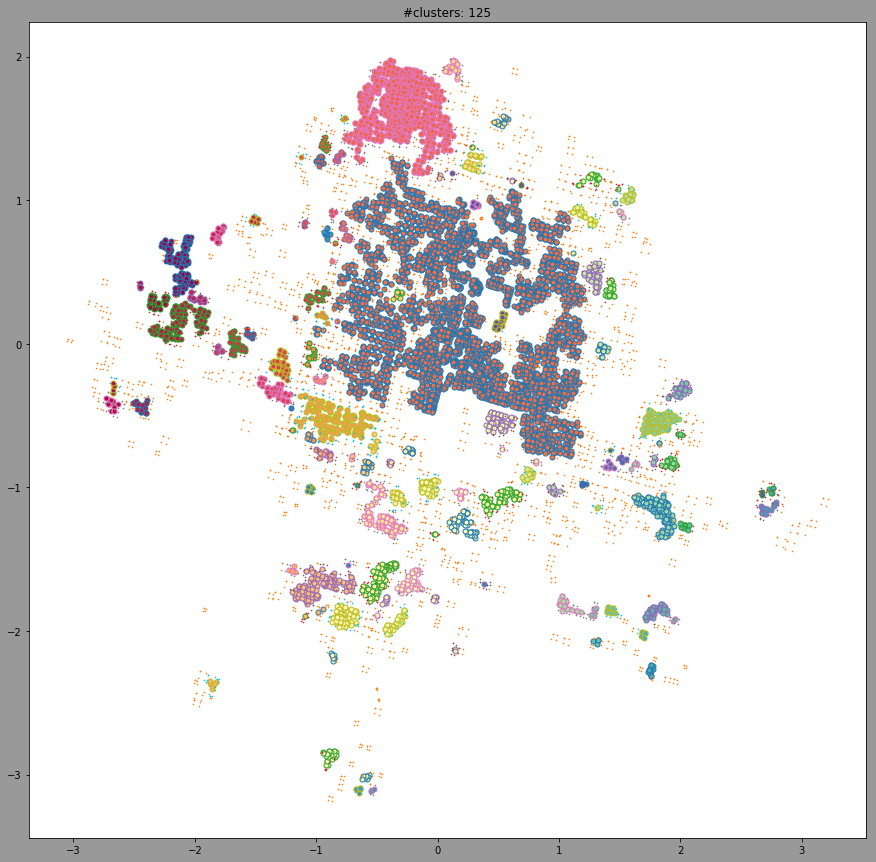

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,15), facecolor='.6')
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=None, markersize=5)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'x', markerfacecolor=tuple(col),
             markeredgecolor=None, markersize=1)


plt.title('#clusters: %d' % n_clusters_)
plt.show()